In [1]:
import os

import matplotlib.pyplot as plt
import torch
import pyro
import copy 

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather, indices_of
import seaborn as sns


import pyro
from pyro.infer import Predictive
import pyro.distributions as dist

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.utils.data_loader import ZoningDataset
from cities.modeling.evaluation import prep_data_for_test, recode_categorical, test_performance

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do



smoke_test = "CI" in os.environ

# use when testing model health
#smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
start = time.time()

zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())
print(data['categorical'].keys())

kwargs = {  
    "categorical": ["year", "month", "zone_id", "neighborhood_id", "ward_id", 
                    "past_reform"],
    "continuous": {'limit_con', 'parcel_area'},
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)
print(subset.keys())

print(zoning_dataset_read.categorical_levels.keys())

dict_keys(['parcel_area', 'car_parking', 'housing_units', 'limit_con', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month', 'day'])
dict_keys(['outcome', 'categorical', 'continuous'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month', 'day'])


In [3]:
# gives the right keys in the trace

units_model = UnitsCausalModel(**subset, categorical_levels=zoning_dataset_read.categorical_levels)

with pyro.poutine.trace() as tr:
    units_model(**subset)

print(tr.trace.nodes.keys())


odict_keys(['data', 'year', 'month', 'zone_id', 'neighborhood_id', 'ward_id', 'past_reform', 'past_reform_by_zone', 'sigma_parcel_area', 'weights_categorical_zone_id_parcel_area', 'weights_categorical_neighborhood_id_parcel_area', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'sigma_limit_con', 'weights_categorical_past_reform_by_zone_limit_con', 'mean_outcome_prediction_limit_con', 'limit_con', 'sigma_housing_units', 'bias_continuous_limit_con_housing_units', 'weight_continuous_limit_con_housing_units_', 'bias_continuous_parcel_area_housing_units', 'weight_continuous_parcel_area_housing_units_', 'weights_categorical_year_housing_units', 'weights_categorical_month_housing_units', 'weights_categorical_zone_id_housing_units', 'weights_categorical_neighborhood_id_housing_units', 'weights_categorical_ward_id_housing_units', 'mean_outcome_prediction_housing_units', 'housing_units'])


[iteration 0001] loss: 5785.2812
[iteration 0050] loss: 5046.7178
[iteration 0100] loss: 4730.3154


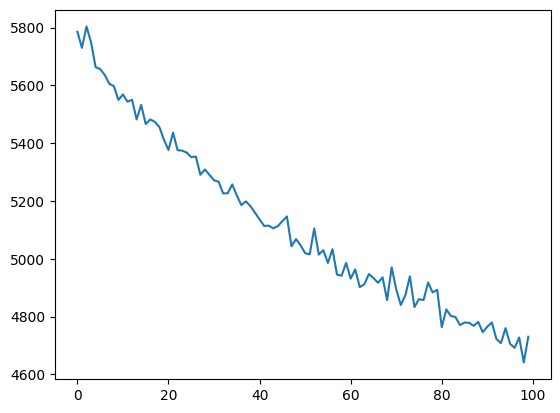

In [4]:
# smoke test inference 

pyro.clear_param_store()
guide = run_svi_inference(units_model, n_steps=100, lr = 0.03,
                           vi_family= AutoDiagonalNormal, **subset)

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


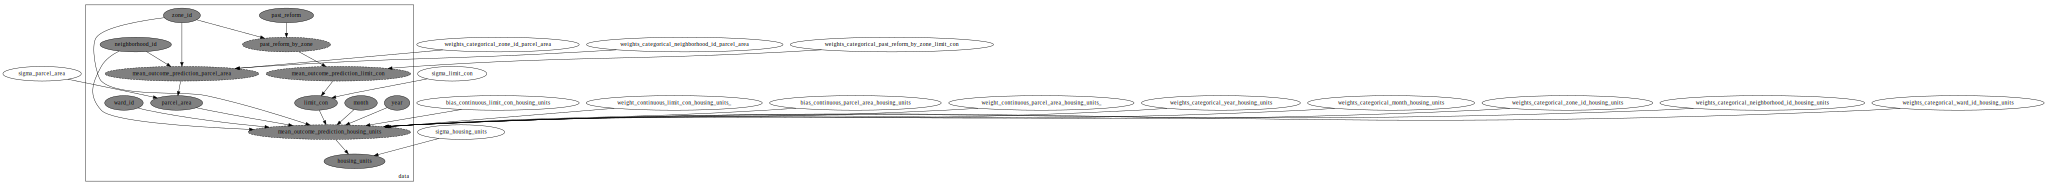

In [5]:
pyro.render_model(lambda:units_model(**subset),
                   filename="units_causal_model.png",
                     render_deterministic=True)

In [6]:

with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
        with pyro.poutine.trace() as tr_do:
            units_model(**subset)

print(tr_do.trace.nodes['limit_con']['value'].shape)

assert tr_do.trace.nodes['limit_con']['value'].shape == torch.Size([2, 1, 1, 1, 302])

torch.Size([2, 1, 1, 1, 302])


In [8]:
train_loader, test_loader, categorical_levels = prep_data_for_test(train_size=0.6)

kwargs = {  
    "categorical": ["year", "month", "zone_id", "neighborhood_id", "ward_id", 
                    "past_reform"],
    "continuous": {'limit_con', 'parcel_area'},
    "outcome": "housing_units",
}

test_performance(
    units_model, kwargs, train_loader, test_loader, categorical_levels, n_steps = n_steps, plot=True, is_class = False
)

[iteration 0001] loss: 3599.8013


[iteration 0001] loss: 5780.9790
[iteration 0050] loss: 5246.5762
[iteration 0100] loss: 4850.1855
[iteration 0150] loss: 4633.3301
[iteration 0200] loss: 4427.7949
[iteration 0250] loss: 4385.8940
[iteration 0300] loss: 4469.4233
[iteration 0350] loss: 4205.3564
[iteration 0400] loss: 4020.4629
[iteration 0450] loss: 4045.0413
[iteration 0500] loss: 3897.3738
[iteration 0550] loss: 4051.3684
[iteration 0600] loss: 3776.3206
[iteration 0650] loss: 3830.8035
[iteration 0700] loss: 3870.6833
[iteration 0750] loss: 3931.8467
[iteration 0800] loss: 3755.2146
[iteration 0850] loss: 3821.5100
[iteration 0900] loss: 3772.7900
[iteration 0950] loss: 3920.9641
[iteration 1000] loss: 3705.7783
[iteration 1050] loss: 3715.4922
[iteration 1100] loss: 3718.2175
[iteration 1150] loss: 3734.4260
[iteration 1200] loss: 3706.0437
[iteration 1250] loss: 3669.2646
[iteration 1300] loss: 3673.4338
[iteration 1350] loss: 3911.1885
[iteration 1400] loss: 3569.2996
[iteration 1450] loss: 3636.2583
[iteration

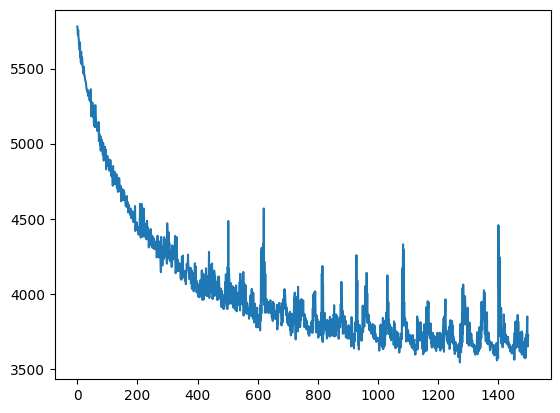

In [ ]:
# inference prior to intervention and prediction
pyro.clear_param_store()
guide = run_svi_inference(units_model, n_steps=n_steps, lr = 0.02,
                          vi_family=AutoDiagonalNormal,
                            **subset)

In [ ]:
predictive = PredictiveModel(units_model, guide)

subset_no_outcome = copy.deepcopy(subset)  

observed_housing_units = subset['outcome'].detach()
subset_no_outcome['outcome'] = None

# print(subset['continuous']['limit_con'])

with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
            with pyro.plate("samples", size = num_samples, dim = -6):
                with pyro.poutine.trace() as tr:
                    hu = predictive(**subset_no_outcome) 

# note doubled sample shapes - won't use PredictiveModel, 
# will stick to pyro.infer.Predictive, which works as desider
# including parallel sampling

print(hu.shape)

print(tr.trace.nodes['housing_units']['value'].shape)


torch.Size([1000, 1000, 2, 1, 1, 1, 302])
torch.Size([1000, 1000, 2, 1, 1, 1, 302])


In [ ]:
predictive = Predictive(model = units_model, guide=guide, num_samples=num_samples)

with MultiWorldCounterfactual() as mwc:
    with do(actions = {'limit_con': torch.tensor(1.)}):
        samples =  predictive(**subset_no_outcome) 

print(
samples['limit_con'].shape
)
print(samples['housing_units'].shape)

assert samples['limit_con'].shape == torch.Size([num_samples, 2, 1, 1, 1, 302])
assert samples['housing_units'].shape == torch.Size([num_samples, 2, 1, 1, 1, 302])

torch.Size([1000, 2, 1, 1, 1, 302])
torch.Size([1000, 2, 1, 1, 1, 302])


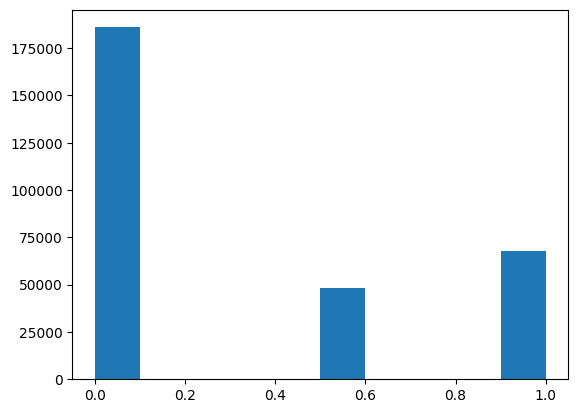

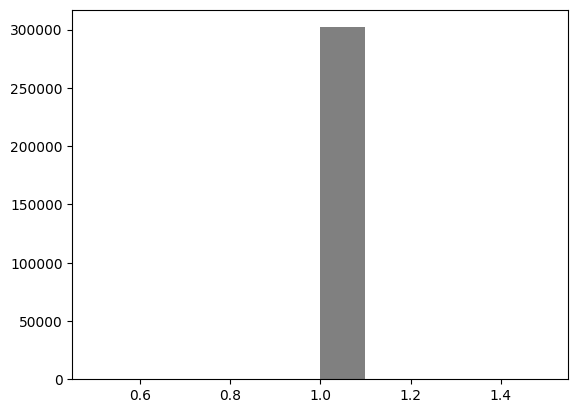

In [ ]:
with mwc:

    factual_limit_con = gather(samples['limit_con'],
                IndexSet(**{"limit_con": {0}}),event_dims=0)
    counterfactual_limit_con = gather(samples['limit_con'],
                IndexSet(**{"limit_con": {1}}), event_dims=0
    )

    factual_housing_units = gather(samples['housing_units'], 
                IndexSet(**{"limit_con": {0}}),event_dims=0)
    
    counterfactual_housing_units = gather(samples['housing_units'],
                IndexSet(**{"limit_con": {1}}),event_dims=0)


plt.hist(factual_limit_con.flatten())
plt.show()
plt.hist(counterfactual_limit_con.flatten(), color = "grey")
plt.show()


In [ ]:
factual_housing_units_means = factual_housing_units.mean(axis = 0).flatten().detach()
factual_housing_units_low = factual_housing_units.quantile(0.05, axis = 0).flatten().detach()
factual_housing_units_high = factual_housing_units.quantile(0.95, axis = 0).flatten().detach()

counterfactual_housing_units_means = counterfactual_housing_units.mean(axis = 0).flatten().detach()
counterfactual_housing_units_low = counterfactual_housing_units.quantile(0.05, axis = 0).flatten().detach()
counterfactual_housing_units_high = counterfactual_housing_units.quantile(0.95, axis = 0).flatten().detach()

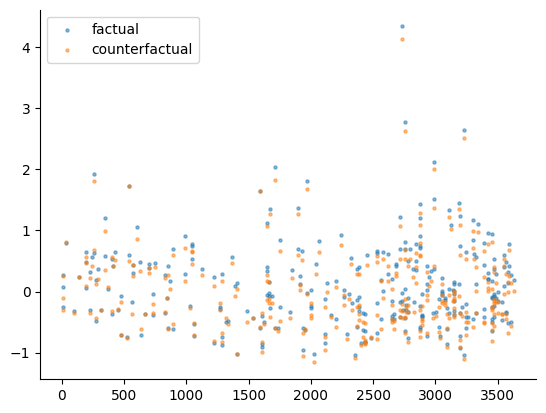

In [ ]:
plt.scatter(x= data['categorical']['day'].numpy(), y = factual_housing_units_means, s= 5, alpha = 0.5, label = "factual")
plt.scatter( x = data['categorical']['day'].numpy(), y = counterfactual_housing_units_means, s = 5, alpha = 0.5, label = "counterfactual")
plt.legend()
sns.despine()
plt.show()

(302,)


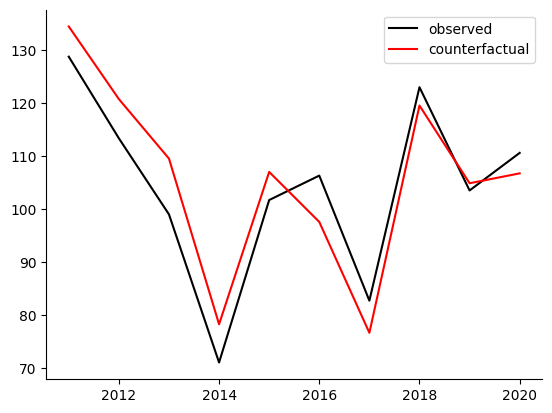

elapsed time since notebook started: 99.91014266014099


In [ ]:
year = (subset['categorical']['year'] + 2011).numpy()
day = data['categorical']['day'].numpy()
print(day.shape)

def destandardize_housing_units(column):
    mean = zoning_dataset_read.standardization_dictionary['housing_units']['mean']
    std = zoning_dataset_read.standardization_dictionary['housing_units']['std']

    return (column * std + mean).round()

observed_df = pd.DataFrame({
    'year': year,
    'day': day,
    'observed_housing_units': destandardize_housing_units(observed_housing_units),
    })


observed_df_by_year = observed_df.groupby('year').mean().reset_index()

counterfactual_df = pd.DataFrame({
    'year': year,
    'day': day,
    'counterfactual_housing_units_mean': destandardize_housing_units(counterfactual_housing_units_means),
    'counterfactual_housing_units_low': destandardize_housing_units(counterfactual_housing_units_low),
    'counterfactual_housing_units_high': destandardize_housing_units(counterfactual_housing_units_high),
    })


counterfactual_df_by_year = counterfactual_df.groupby('year').mean().reset_index()

plt.plot(observed_df_by_year['year'], observed_df_by_year['observed_housing_units'], color = "black", label = "observed")
plt.plot(observed_df_by_year['year'], counterfactual_df_by_year['counterfactual_housing_units_mean'], color = "red", label = "counterfactual")
plt.legend()
sns.despine()
plt.show()

end = time.time()
print(f"elapsed time since notebook started: {end - start}")
